In [16]:
## let's import the relevant libraries
import torch
import torch.nn as nn
from time import perf_counter
from PIL import Image
import matplotlib.pyplot as plt
from functools import partial
import numpy as np
import requests
import os

## check if GPU is available and use it; otherwise use CPU
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

## Example 1: Single ODE

Consider the ode:
$$
\frac{d\Psi}{dx} = f(x, \Psi),
$$
with $x \in [0,1]$ and initial conditions (IC):
$$
\Psi(0) = A.
$$
We write the trial solution by:
$$
\hat{\Psi}(x; \theta) = A + x N(x; \theta),
$$
where $N(x; \theta)$ is a neural network (NN).
The solution is $\hat{\Psi}(x;\theta)$ automatically satisfied the initial conditions.
The loss function we would like to minimize to train the NN is:
$$
L(\theta) = \int_0^1 \left[\frac{d\hat{\Psi}(x;\theta)}{dx} - f(x,\hat{\Psi}(x;\theta))\right]^2dx
$$
 -------------------
Function is: 
$$
f(x) = \cos(x) e^\frac{-x}{5} - \frac{\Psi}{5}
$$

True solution is:
$$
\Psi = e^\frac{-x}{5} \sin(x)
$$

In [17]:
# N is a Neural Network - This is exactly the network used by Lagaris et al. 1997
N = nn.Sequential(nn.Linear(1, 50), nn.Sigmoid(), nn.Linear(50,1, bias=False))

# Initial condition
A = 0.

# The Psi_t function
Psi_t = lambda x: A + x * N(x)

# The right hand side function
f = lambda x, Psi: torch.exp(-x / 5.0) * torch.cos(x) - Psi / 5.0

# The loss function
def loss(x):
    x.requires_grad = True
    outputs = Psi_t(x)
    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs),
                                  create_graph=True)[0]
    return torch.mean((Psi_t_x - f(x, outputs)) ** 2)

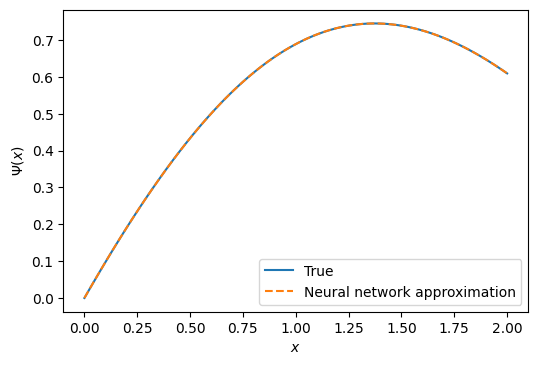

In [18]:
# Optimize (same algorithm as in Lagaris)
optimizer = torch.optim.LBFGS(N.parameters())

# The collocation points used by Lagaris
x = torch.Tensor(np.linspace(0, 2, 100)[:, None])

# Run the optimizer
def closure():
    optimizer.zero_grad()
    l = loss(x)
    l.backward()
    return l
    
for i in range(10):
    optimizer.step(closure)

# Let's compare the result to the true solution
xx = np.linspace(0, 2, 100)[:, None]
with torch.no_grad():
    yy = Psi_t(torch.Tensor(xx)).numpy()
yt = np.exp(-xx / 5.0) * np.sin(xx)

fig, ax = plt.subplots(dpi=100)
ax.plot(xx, yt, label='True')
ax.plot(xx, yy, '--', label='Neural network approximation')
ax.set_xlabel('$x$')
ax.set_ylabel('$\Psi(x)$')
plt.legend(loc='best');